In [27]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
data = pd.read_csv('./results/all_results_df.csv')
data

,Corpus,Type,TTR,MATTR,Char Entr,Word Entr,Text Entr,Lex Entr,Rev Lex Entr
0,id,nat,5.804406,0.700090,4.070997,11.148131,3.595690,1.944459,1.984659
1,tl,nat,7.498319,0.609710,3.894602,9.976462,3.544414,1.881334,1.922877
2,tr,nat,13.993292,0.827652,4.386971,13.166179,4.257474,1.561815,1.662302
3,en,nat,6.025770,0.697744,4.166890,10.690033,4.138779,1.916237,1.965091
4,de,nat,12.010972,0.769293,4.230064,11.598005,4.002635,1.612682,1.695224
5,fr,nat,7.304848,0.721023,4.177654,10.715771,3.625466,1.787924,1.874849
6,eo,con,10.589734,0.692378,4.164256,10.920602,3.909751,1.788268,1.893195
7,lfn,con,5.083459,0.600948,3.912139,9.320495,4.059735,2.000799,2.111598
8,ia,con,6.795857,0.596837,4.030916,9.935303,3.762086,1.834966,1.910784
9,io,con,3.677265,0.566818,4.083562,8.296066,1.153088,1.981079,2.089008


In [29]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':0, 'nat':1}).values

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [30]:
clf = tree.DecisionTreeClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

kfold = KFold(n_splits=len(X), shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    verbose=1,
)

grid_search.fit(X, y)
print("Best parameters: ", grid_search.best_params_)

# Best estimator fitted with best parameters
best_clf = grid_search.best_estimator_

Fitting 22 folds for each of 144 candidates, totalling 3168 fits
Best parameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


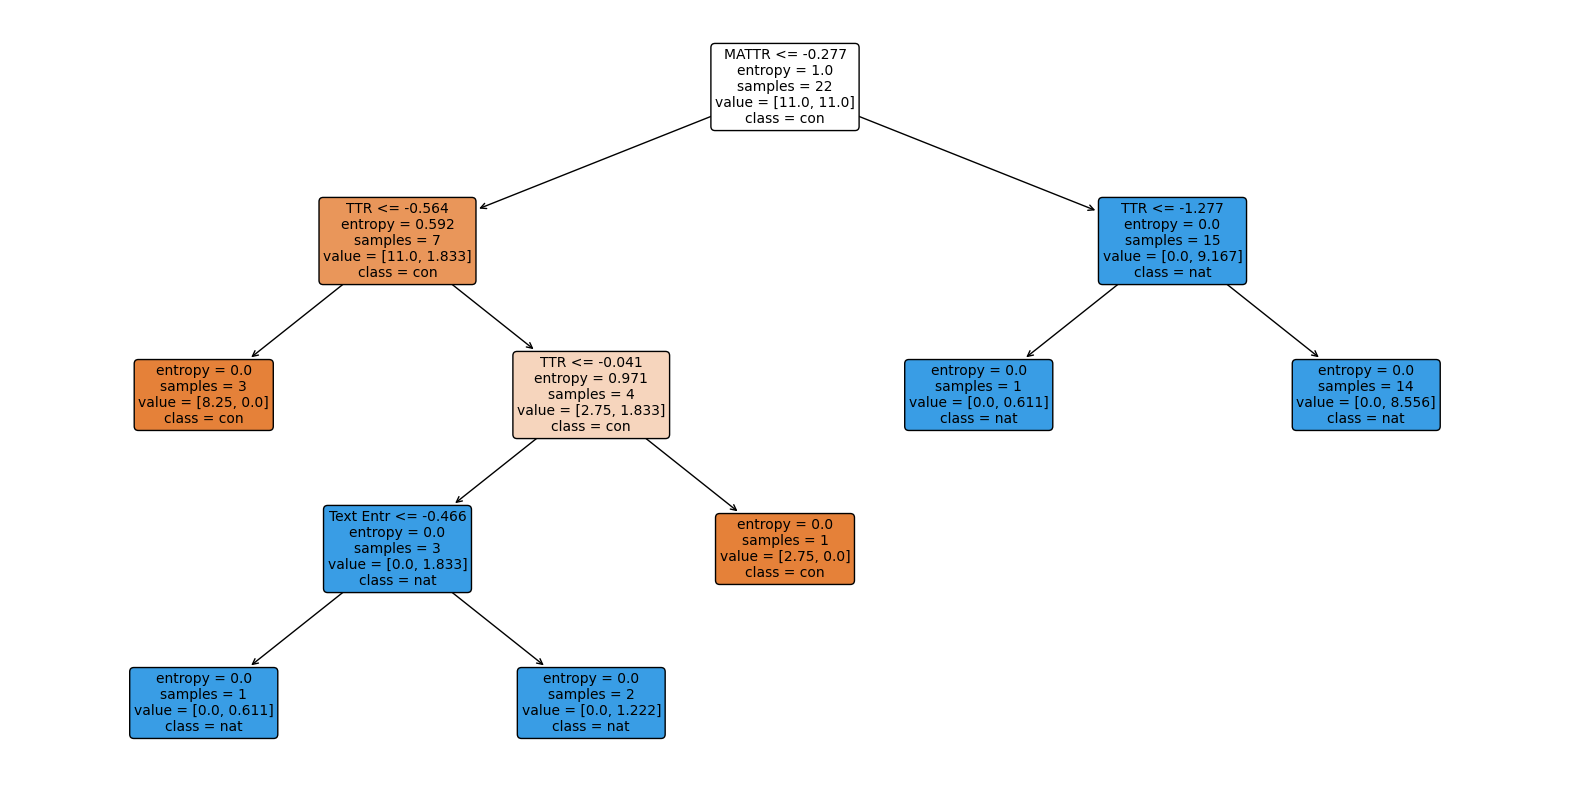

In [31]:
plt.figure(figsize=(20, 10))
tree.plot_tree(best_clf, filled=True, feature_names=['TTR', 'MATTR', 'Char Entr', 'Word Entr', 'Text Entr', 'Lex Entr', 'Rev Lex Entr'], class_names=['con', 'nat'], rounded=True, fontsize=10)
plt.show()

In [12]:
# loo = LeaveOneOut()
# cross_val_scores = cross_val_score(clf, X, y, cv=kfold)

# predictions = clf.predict(X)
# print(accuracy_score(y, predictions))

# print("Cross-validation scores: ", cross_val_scores)
# print("Mean accuracy: ", cross_val_scores.mean())